In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns 
import statsmodels.stats.proportion as proportion
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind,mannwhitneyu,shapiro,norm
from statsmodels.stats.weightstats import ztest
from tqdm import tqdm
import timeit
from scipy import stats
import math
from datetime import date, datetime, timedelta
import time
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
import warnings
warnings.filterwarnings("ignore")
import clickhouse_connect  


sys.path.append('/Users/kemran/Desktop/work_files/python_files') 
from credential import postgres_secret,clickhouse_dwh_secret

def get_engine(user):
    if user == postgres_secret['user']:
        db_name = postgres_secret['db_name']
        password = postgres_secret['password']
        host = postgres_secret['host']
        engine = create_engine(f'postgresql://{user}:{password}@{host}:6432/{db_name}')
    elif user == clickhouse_dwh_secret['user']:
            db_name = clickhouse_dwh_secret['db_name'] 
            password = clickhouse_dwh_secret['password']
            host = clickhouse_dwh_secret['host']
            engine = create_engine(f'clickhouse://{user}:{password}@{host}:8123/{db_name}')
    return engine
    
connection_clickhouse = clickhouse_connect.get_client(
    host = clickhouse_dwh_secret['host'],
    port= '8123',
    username = clickhouse_dwh_secret['user'],
    password = clickhouse_dwh_secret['password'],
    database='datamarts'
    )

    
def execute(SQL, user):
    start_time = time.time()  # запоминаем время начала выполнения функции
    engine = get_engine(user)
    Session = sessionmaker(bind=engine)  # sessions factory ()
    with Session() as session: # open session
        result = session.execute(text(SQL))
        df = pd.DataFrame(result.fetchall(), columns=result.keys())
        
    end_time = time.time()  # запоминаем время окончания выполнения функции
    execution_time = round(end_time - start_time,4) # вычисляем время выполнения   
    
    print(f"Время выполнения функции: {execution_time} секунд")
    print()
    return df

In [96]:
query = f'''
WITH all_info AS (SELECT  
        s.user_id AS user_id,
        t3.created_at::date as trial_start,
        s.id AS id,
       -- leadInFrame(id) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_id,
        i.state as invoice_state,
        --leadInFrame(invoice_state) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_invoice_state,
        i.id as invoice_id,
        i.created_at as invoice_created_at,
        --leadInFrame(invoice_created_at) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_invoice_created_at,  
      --  next_invoice_created_at::date - invoice_created_at::date delta_date,
        i.price_cents AS price_cents,
        i.price_currency AS price_currency,
        i.refund_amount_cents AS refund_amount_cents,
        t4.bonus_title_new AS bonus_title_new,
        ROW_NUMBER() OVER (PARTITION BY user_id,id,user_type,invoice_state ORDER BY invoice_created_at) AS rn_num,
        CASE WHEN price_cents<=100 AND invoice_state='success' THEN 'trial'
             WHEN price_cents<=100 AND invoice_state IN ('failure','initial') THEN 'not_success_trial'
             ELSE 'subs'
             END user_type,
        leadInFrame(user_type) OVER (PARTITION BY user_id ORDER BY invoice_created_at  ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS next_user_type, 
        t2.renewal_off_date AS renewal_off_date,
        CASE WHEN renewal_off_date!='1970-01-01' THEN 1 ELSE 0 END unsubscribe_type,
        t3.free_days AS free_days,
        t3.offer_duration AS offer_duration,
        t3.promo_type,
        i.paid_at AS paid_at,
        --i.period_end,
        s.platform AS platform,
       -- i.payment_target,
        i.deleted_at,
        i.refunded_at
    FROM raw.viju__product_x__public__invoices i
    LEFT JOIN raw.viju__product_x__public__subscriptions s 
        ON i.subscription_id = s.id  
    LEFT JOIN (SELECT
                subscription_id,
                max(created_at) as renewal_off_date
                FROM raw.viju__product_x__public__subscription_cancel_reasons
                WHERE created_at >= '2022-03-01'
                 --AND subscription_id='74bcff94-4ada-40ef-85de-25074d615d57'
                GROUP by 1
                ) AS t2 ON i.subscription_id=t2.subscription_id
    INNER JOIN datamarts.marketing_dash AS t3 ON s.user_id=t3.user_id
    LEFT JOIN datamarts.mekhtiev_bonus_distr AS t4 ON t3.bonus_title=t4.bonus_title_old
    WHERE s.platform != 'api'
    ORDER BY s.user_id, invoice_created_at 
    )
--    
SELECT * FROM all_info
WHERE invoice_created_at::date BETWEEN '2025-03-25' AND '2025-04-07'
--AND user_type!='not_success_trial'
-- platform!='payture'
AND free_days!='28'
--AND invoice_state!='initial'
'''
df = execute(query,user='kmekhtiev')

Время выполнения функции: 7.4345 секунд



# Расчитем целевую метрику - конверсия в оплату

In [98]:
df_test = pd.read_csv('group_b_test_ids.csv')
df_control = pd.read_csv('group_a_control_ids.csv')

In [99]:
df_merge_test = pd.merge(df,df_test,how='inner',on='user_id',indicator='group')

df_merge_control = pd.merge(df,df_control,how='inner',on='user_id',indicator='group')

df_merge_test['group'] = df_merge_test['group'].apply(lambda x:'test' if x=='both' else 'control')
df_merge_control['group'] = df_merge_control['group'].apply(lambda x:'control' if x=='both' else 'control')

In [103]:
df_merge_test['user_id'].nunique()

2259

In [105]:
df_merge_control['user_id'].nunique()

2246

In [107]:
# Тестовая группа
df_merge_test['rn_num_2'] = df_merge_test.groupby(['user_id','invoice_state']).cumcount()+1
df_merge_test[df_merge_test['rn_num_2']>1].groupby('invoice_state')['user_id'].nunique()

invoice_state
failure    932
initial      2
success      1
Name: user_id, dtype: int64

In [109]:
# Тестовая группа
df_merge_test[(df_merge_test['rn_num_2']>=1) & (df_merge_test['invoice_state']=='failure')].groupby('rn_num_2')['user_id'].nunique()

rn_num_2
1     1056
2      932
3      828
4      748
5      690
6      528
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
Name: user_id, dtype: int64

In [111]:
# Контрольная группа
df_merge_control['rn_num_2'] = df_merge_control.groupby(['user_id','invoice_state']).cumcount()+1
df_merge_control[df_merge_control['rn_num_2']>1].groupby('invoice_state')['user_id'].nunique()

invoice_state
failure    979
initial      2
Name: user_id, dtype: int64

In [113]:
# Контрольная группа
df_merge_control[(df_merge_control['rn_num_2']>=1) & (df_merge_control['invoice_state']=='failure')].groupby('rn_num_2')['user_id'].nunique()

rn_num_2
1    1051
2     979
3     936
4     876
5       6
6       4
Name: user_id, dtype: int64

In [115]:
df_merge_control[df_merge_control['invoice_state']=='success']['user_id'].nunique()/df_merge_control['user_id'].nunique()

0.5302760463045414

In [117]:
df_merge_control.groupby('invoice_state')['user_id'].nunique()

invoice_state
failure     1051
initial       36
refunded      25
success     1191
Name: user_id, dtype: int64

In [119]:
df_merge_test[df_merge_test['invoice_state']=='success']['user_id'].nunique()/df_merge_test['user_id'].nunique()

0.5489154493138557

In [121]:
df_merge_test.groupby('invoice_state')['user_id'].nunique()

invoice_state
failure     1056
initial       38
refunded      32
success     1240
Name: user_id, dtype: int64

In [123]:
df_merge_test['payment'] = df_merge_test['invoice_state'].apply(lambda x:1 if x=='success' else 0)
df_merge_test_wo_duplic = df_merge_test[['user_id','free_days','payment']].drop_duplicates()
df_merge_test_wo_duplic['group'] = 'test'

df_merge_test_wo_duplic[df_merge_test_wo_duplic['payment']==1]['user_id'].count()/df_merge_test_wo_duplic['user_id'].count()

0.5305947796320069

In [125]:
df_merge_control['payment'] = df_merge_control['invoice_state'].apply(lambda x:1 if x=='success' else 0)
df_merge_control_wo_duplic = df_merge_control[['user_id','free_days','payment']].drop_duplicates()
df_merge_control_wo_duplic['group'] = 'control'


df_merge_control_wo_duplic[df_merge_control_wo_duplic['payment']==1]['user_id'].count()/df_merge_control_wo_duplic['user_id'].count()

0.5228270412642669

In [127]:
df_all = pd.concat([df_merge_test_wo_duplic,df_merge_control_wo_duplic],ignore_index=True)

## Функции для стратификации

In [130]:
def calculate_stratified_mean(df, weights,parameter):
    strat_mean = df.groupby('free_days')[parameter].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()
    mean_strat = (df_means_weights['weight'] * df_means_weights[parameter]).sum()
    return mean_strat

In [132]:
def calculate_strat_var(df, weights, parameter):
    """Вычисляет стратифицированную дисперсию."""
    """ Parametr - поле конверсии """
    strat_vars = df.groupby('free_days')[parameter].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights[parameter]).sum()
    return var_strat

In [134]:
def check_stratified_test(df_control, df_pilot, weights, parameter):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего."""
    mean_strat_control = calculate_stratified_mean(df_control, weights, parameter)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights, parameter)
    var_strat_control = calculate_strat_var(df_control, weights, parameter)
    var_strat_pilot = calculate_strat_var(df_pilot, weights, parameter)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

In [136]:
weights = df_all['free_days'].value_counts(normalize=True).to_dict()

print(calculate_strat_var(df_all,weights,'payment'))
print(df_all['payment'].var())

0.23486227446858682
0.24933789996155442


## Симмуляция Монте-Карло

In [139]:
num_of_bucket = 2

control = df_all[df_all['group']=='control']
test_1 = df_all[df_all['group']=='test']

BOLD = "\033[1m"  
END = "\033[0m" 

In [141]:
def mde_estimated_absolute (ttl_users,var,alpha,beta):
    """ Учитываем поправку на множественное тестирование и снижаем альфу по методу Бонферрони """
    t_alpha = stats.norm.ppf(1 - alpha /(num_of_bucket - 1) / 2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    var = var * 2
    MDE=(t_alpha+t_beta) * np.sqrt(var / ttl_users)
    return MDE

In [143]:
num_of_bucket=2
ttl_users = math.ceil(df_all['user_id'].count() / num_of_bucket)
var = df_all['payment'].var()
mean = df_all['payment'].mean()

mde_absolute = mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean
print(f"{BOLD}Период(дни) - 7 {END}") 
print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Среднияя конверсия в отписку:',round(mean,4))
print('Дисперсия:',round(var,4))
print('Число пользователей в группе:',math.ceil(ttl_users))

Период(дни) - 7 
MDE абсолютный: 0.0412
MDE относительный: 0.0782
Среднияя конверсия в отписку: 0.5268
Дисперсия: 0.2493
Число пользователей в группе: 2308


100%|██████████| 10000/10000 [00:04<00:00, 2319.91it/s]



Эффект = 0
Период (дни) - 7 дней
Итераций с p_value < 0.05: 547
Число пользователей всего: 4506

Эффект = 0.0782
Период (дни) - 7 дней
Итераций с p_value < 0.05: 7546
Число пользователей всего: 4506


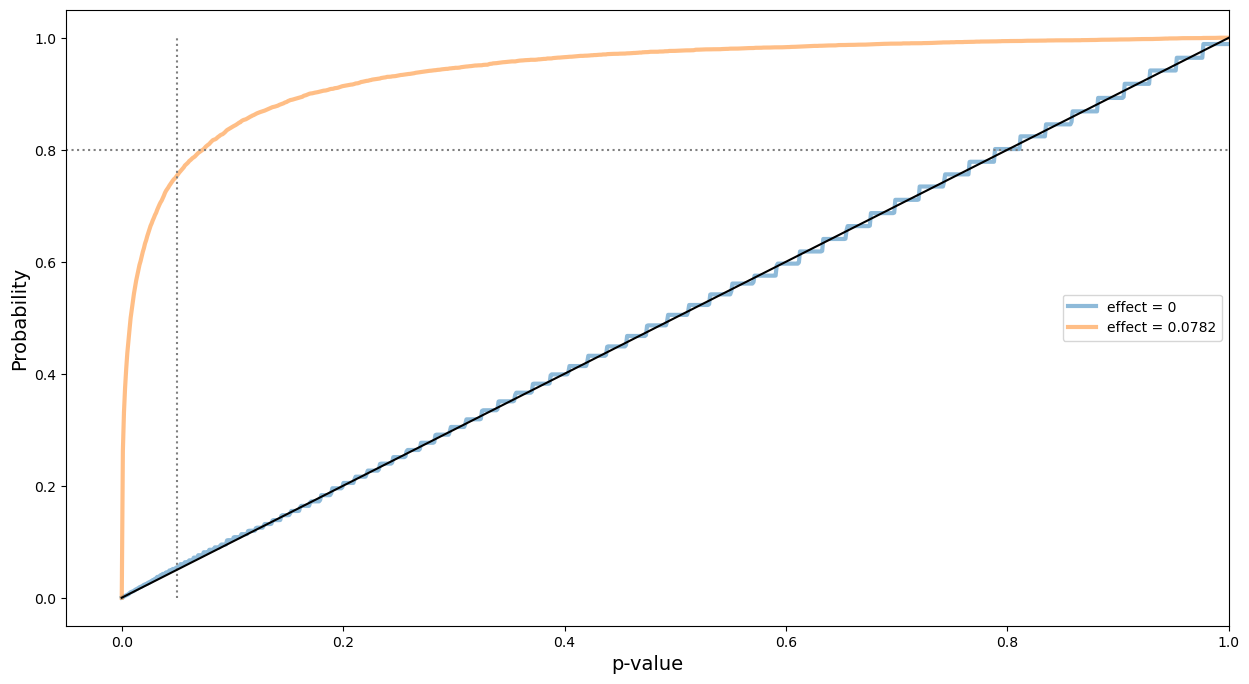

In [145]:
effects = [0,0.0782]

# Хранение p-values для каждого значения эффекта
pvalues_dict = {}


for effect in effects:
    ttl_users = math.ceil(df_all['user_id'].nunique() / num_of_bucket)
    pvalues_ttest = []
    for i in tqdm(range(10000)):
    
        df_control = df_all.sample(n=ttl_users, replace=True)
        df_pilot = df_all.sample(n=ttl_users, replace=True)
        df_pilot = df_pilot['payment'] * (1 + effect)

        # Проведение t-теста
        _,p_value = ttest_ind(df_control['payment'], df_pilot)
        pvalues_ttest.append(p_value)
        
    pvalues_dict[effect] = pvalues_ttest  # Сохраняем p-values для текущего эффекта
        

# Визуализация результатов
plt.figure(figsize=(15, 8))
X = np.linspace(0, 1, 1000)

for effect, pvalues in pvalues_dict.items():
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=f'effect = {effect}')
    print()
    print(f"Эффект = {effect}")
    print(f"Период (дни) - 7 дней")
    print(f'Итераций с p_value < 0.05:', len([p for p in pvalues if p < 0.05]))
    print(f'Число пользователей всего:', ttl_users * 2)

plt.xlabel('p-value', size=14)
x_values = [0.05]
plt.vlines(x_values, ymin=0, ymax=1, linestyles='dotted', colors='gray')
plt.axhline(y=0.8, color='gray', linestyle='dotted')
plt.xlim([-0.05, 1])
plt.ylabel('Probability', size=14)
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

## Подсчет метрики конверсия в оплату

In [147]:
weights = df_all['free_days'].value_counts(normalize=True).to_dict()

cr_control = calculate_stratified_mean(control, weights, 'payment')
cr_test = calculate_stratified_mean(test_1, weights, 'payment')
cr_test = test_1['payment'].mean()
test_to_control = check_stratified_test(control, test_1, weights, 'payment')

In [148]:
test_1['payment'].mean()

0.5305947796320069

In [149]:
control['payment'].mean()

0.5228270412642669

In [154]:
final_table_register = []

row1 = [cr_control, cr_test, test_to_control]

final_table_register.append(row1)



final_table_register = pd.DataFrame(final_table_register, index=['Конверсия в оплату'], columns=['Контроль', 'Тест', 'p_value'])
final_table_register['Тест к контролю (%)'] = np.where(final_table_register['p_value'].isna(), 0, np.where(final_table_register['p_value']<0.05/num_of_bucket, round((final_table_register['Тест'] / final_table_register['Контроль'] - 1) * 100,3), 'Нет различия'))
final_table_register['Тест к контролю (п.п.)'] = np.where(final_table_register['p_value'].isna(), 0, np.where(final_table_register['p_value']<0.05/num_of_bucket, round((final_table_register['Тест'] - final_table_register['Контроль']),3), 'Нет различия'))
final_table_register[['Контроль','Тест']] = final_table_register[['Контроль','Тест']].round(3).astype('str')

final_table_register

,Контроль,Тест,p_value,Тест к контролю (%),Тест к контролю (п.п.)
Конверсия в оплату,0.523,0.531,0.713873,Нет различия,Нет различия


# Исследуем сегмент пользователей,у которых было неудачное списание 

In [157]:
df_merge_test['rn_num3'] = df_merge_test.groupby('user_id').cumcount()+1
df_merge_test[(df_merge_test['rn_num3']>1) & (df_merge_test['invoice_state']=='success')]['user_id'].nunique() / df_merge_test[(df_merge_test['rn_num3']>1)]['user_id'].nunique()

0.07991803278688525

In [159]:
df_merge_control['rn_num3'] = df_merge_control.groupby('user_id').cumcount()+1
df_merge_control[(df_merge_control['rn_num3']>1) & (df_merge_control['invoice_state']=='success')]['user_id'].nunique() / df_merge_control[(df_merge_control['rn_num3']>1)]['user_id'].nunique()

0.03229061553985873

In [161]:
condition_test = (df_merge_test['rn_num3'] > 1) & (df_merge_test['invoice_state'] == 'success')  
df_merge_test['after_failure'] = np.where(condition_test, 1, 0)


condition_control = (df_merge_control['rn_num3'] > 1) & (df_merge_control['invoice_state'] == 'success')  
df_merge_control['after_failure'] = np.where(condition_control, 1, 0)

In [163]:
c = df_merge_control[(df_merge_control['rn_num3']>1)]
t = df_merge_test[(df_merge_test['rn_num3']>1)]

df_concat_after_failure = pd.concat([t,c],ignore_index=True)

In [165]:
df_merge_control[(df_merge_control['rn_num3']>1)]

,user_id,trial_start,id,invoice_state,invoice_id,invoice_created_at,price_cents,price_currency,refund_amount_cents,bonus_title_new,...,t3.promo_type,paid_at,platform,i.deleted_at,i.refunded_at,group,rn_num_2,payment,rn_num3,after_failure
1,ffba2d95-0a88-440e-8009-946227d87457,2025-02-26,5c82242b-ef75-43de-8869-7b6cf9dee772,failure,2c63155a-b8ef-4ee4-920a-0ec75ed80e0d,2025-04-02 15:00:47.947,39900,RUB,0,,...,promo,NaT,cloudpayments,NaT,NaT,control,2,0,2,0
2,ffba2d95-0a88-440e-8009-946227d87457,2025-02-26,5c82242b-ef75-43de-8869-7b6cf9dee772,failure,bd80c0b6-4bc6-44c0-9364-6e497b188809,2025-04-02 16:00:32.148,39900,RUB,0,,...,promo,NaT,cloudpayments,NaT,NaT,control,3,0,3,0
3,ffba2d95-0a88-440e-8009-946227d87457,2025-02-26,5c82242b-ef75-43de-8869-7b6cf9dee772,failure,8e46686b-5049-4097-8e55-d0b1717d0a0a,2025-04-02 17:00:23.945,39900,RUB,0,,...,promo,NaT,cloudpayments,NaT,NaT,control,4,0,4,0
8,c8b8e709-8020-499f-803d-755115a4ca07,2025-03-01,317a30a6-b411-4561-b780-68c45289c652,failure,31cff7b0-7d49-4cfc-acb3-919c69cf261b,2025-04-05 01:00:32.949,39900,RUB,0,RIS,...,promo,NaT,cloudpayments,NaT,NaT,control,2,0,2,0
9,c8b8e709-8020-499f-803d-755115a4ca07,2025-03-01,317a30a6-b411-4561-b780-68c45289c652,failure,1a7b2eb5-4724-4dae-8b87-3288e5c60bce,2025-04-05 02:00:39.058,39900,RUB,0,RIS,...,promo,NaT,cloudpayments,NaT,NaT,control,3,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092,186c8b35-0238-4472-bfc5-31894b5431fd,2025-03-14,c0e4cc43-4b75-44e0-aaf8-46182a995bb2,failure,1ca088ca-c9b7-454c-bd65-026a652f8ebd,2025-03-28 12:01:13.977,29900,RUB,0,,...,no_promo,NaT,cloudpayments,NaT,NaT,control,3,0,3,0
5093,186c8b35-0238-4472-bfc5-31894b5431fd,2025-03-14,c0e4cc43-4b75-44e0-aaf8-46182a995bb2,failure,fdf99533-0264-42c4-8936-0359661abe7a,2025-03-28 13:01:14.112,29900,RUB,0,,...,no_promo,NaT,cloudpayments,NaT,NaT,control,4,0,4,0
5100,936dc396-2a7d-491a-bfe5-b13b03a95765,2025-03-05,d3514dfd-f643-475f-b170-32f7f85a40d7,failure,a86ce7be-1eee-431f-8813-d168714eb52c,2025-04-04 21:01:00.361,29900,RUB,0,Яндекс Директ. 1 месяц за 1 рубль.,...,promo,NaT,cloudpayments,NaT,NaT,control,2,0,2,0
5101,936dc396-2a7d-491a-bfe5-b13b03a95765,2025-03-05,d3514dfd-f643-475f-b170-32f7f85a40d7,failure,2ad45898-2af5-4fa8-9b13-3404517283b5,2025-04-04 22:01:00.076,29900,RUB,0,Яндекс Директ. 1 месяц за 1 рубль.,...,promo,NaT,cloudpayments,NaT,NaT,control,3,0,3,0


In [171]:
df_concat_after_failure = df_concat_after_failure[['user_id','free_days','after_failure','group']].drop_duplicates()

df_concat_after_failure[df_concat_after_failure['group']=='test']['after_failure'].mean()

0.0769990128331688

In [173]:
num_of_bucket=2
ttl_users = math.ceil(df_concat_after_failure['user_id'].count() / num_of_bucket)
var = df_concat_after_failure['after_failure'].var()
mean = df_concat_after_failure['after_failure'].mean()

mde_absolute = mde_estimated_absolute(ttl_users,var,0.05,0.2)
MDE = mde_absolute / mean
print(f"{BOLD}Период(дни) - 7 {END}") 
print('MDE абсолютный:',round(mde_absolute,4))
print('MDE относительный:',round(MDE,4))
print('Среднияя конверсия в отписку:',round(mean,4))
print('Дисперсия:',round(var,4))
print('Число пользователей в группе:',math.ceil(ttl_users))

Период(дни) - 7 
MDE абсолютный: 0.0282
MDE относительный: 0.5195
Среднияя конверсия в отписку: 0.0543
Дисперсия: 0.0514
Число пользователей в группе: 1013


In [219]:
control = df_concat_after_failure[df_concat_after_failure['group']=='control']
test_1 = df_concat_after_failure[df_concat_after_failure['group']=='test']


final_table_register = []

_,p_val = ttest_ind(control['after_failure'],test_1['after_failure'],equal_var=False)

row1 = [control['after_failure'].mean(), test_1['after_failure'].mean(), p_val]

final_table_register.append(row1)



final_table_register = pd.DataFrame(final_table_register, index=['Конверсия в оплату'], columns=['Контроль', 'Тест', 'p_value'])
final_table_register['Тест к контролю (%)'] = np.where(final_table_register['p_value'].isna(), 0, np.where(final_table_register['p_value']<0.05/num_of_bucket, round((final_table_register['Тест'] / final_table_register['Контроль'] - 1) * 100,3), 'Нет различия'))
final_table_register['Тест к контролю (п.п.)'] = np.where(final_table_register['p_value'].isna(), 0, np.where(final_table_register['p_value']<0.05/num_of_bucket, round((final_table_register['Тест'] - final_table_register['Контроль']),3), 'Нет различия'))
final_table_register[['Контроль','Тест']] = final_table_register[['Контроль','Тест']].round(3).astype('str')

def format_with_sign(x):
    try:
        val = float(x)
        return f"{val:+.3f}"
    except:
        return x

final_table_register['Тест к контролю (%)'] = final_table_register['Тест к контролю (%)'].apply(format_with_sign)
final_table_register['Тест к контролю (п.п.)'] = final_table_register['Тест к контролю (п.п.)'].apply(format_with_sign)

final_table_register

,Контроль,Тест,p_value,Тест к контролю (%),Тест к контролю (п.п.)
Конверсия в оплату,0.032,0.077,0.000006,+143.509,+0.045


In [221]:
def color_cell(val):
    if val == 'Нет различия':
        return ''
    elif '+' in val:
        return 'background-color: lightgreen'
    else:
        return 'background-color:  #FFCCCB'

In [223]:
final_table_register[['Контроль', 'Тест','Тест к контролю (%)', 'Тест к контролю (п.п.)']].style.applymap(color_cell, subset=['Тест к контролю (%)','Тест к контролю (п.п.)'])

,Контроль,Тест,Тест к контролю (%),Тест к контролю (п.п.)
Конверсия в оплату,0.032,0.077,+143.509,+0.045


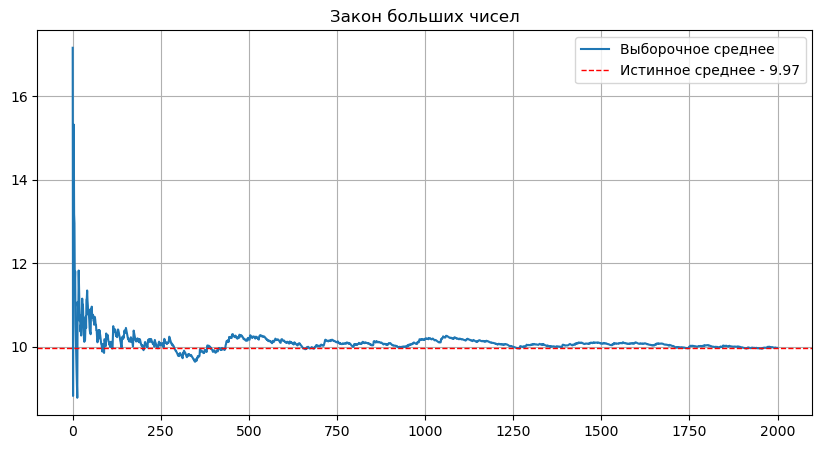

In [197]:
n = 2000
scale = 10
s = np.random.exponential(scale = scale,size = n)
cum_avg = np.cumsum(s) / np.arange(1,n + 1)

plt.figure(figsize=(10,5))
sns.lineplot(data = cum_avg,label = 'Выборочное среднее')
plt.axhline(y = s.mean(),color='r',linewidth=1,linestyle = '--',label = f'Истинное среднее - {round(s.mean(),2)}')
plt.grid(visible = True)
plt.title('Закон больших чисел')
plt.legend()
plt.show()